## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import numpy.ma as ma
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from multiprocessing import Pool
from textblob import TextBlob
import re
from matplotlib.pyplot import figure
from matplotlib import rcParams
from sklearn.preprocessing import OneHotEncoder

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import  AdaBoostRegressor
import xgboost as xgb
import lightgbm as lgbm

import sklearn.model_selection as model_selection
import pickle
import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


## Importing Data

In [2]:
df=pd.read_csv('Reddit_data.csv')

In [3]:
print("The columns present are ", df.columns)

The columns present are  Index(['Unnamed: 0', 'body', 'created_utc', 'ups', 'downs', 'upvote_ratio',
       'score', 'gilded', 'over_18', 'number_of_Comments', 'author',
       'archived', 'edited', 'link_id', 'url'],
      dtype='object')


In [5]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)


## Exploring Data 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7574 entries, 0 to 7573
Data columns (total 14 columns):
body                  7574 non-null object
created_utc           7574 non-null float64
ups                   7574 non-null int64
downs                 7574 non-null int64
upvote_ratio          7574 non-null float64
score                 7574 non-null int64
gilded                7574 non-null int64
over_18               7574 non-null bool
number_of_Comments    7574 non-null int64
author                7574 non-null object
archived              7574 non-null bool
edited                7574 non-null object
link_id               7574 non-null object
url                   7574 non-null object
dtypes: bool(2), float64(2), int64(5), object(5)
memory usage: 724.9+ KB


In [8]:
df.describe()

,created_utc,ups,downs,upvote_ratio,score,gilded,number_of_Comments
count,7.574000e+03,7574.000000,7574.0,7574.000000,7574.000000,7574.000000,7574.000000
mean,1.610494e+09,4221.566015,0.0,0.971473,4221.566015,0.055849,107.735939
std,1.993593e+04,10836.421861,0.0,0.032272,10836.421861,0.326920,406.792304
min,1.610446e+09,61.000000,0.0,0.610000,61.000000,0.000000,0.000000
25%,1.610478e+09,337.000000,0.0,0.960000,337.000000,0.000000,12.000000
50%,1.610495e+09,891.500000,0.0,0.980000,891.500000,0.000000,31.000000
75%,1.610509e+09,2899.750000,0.0,0.990000,2899.750000,0.000000,84.000000
max,1.610531e+09,147591.000000,0.0,1.000000,147591.000000,8.000000,20590.000000


## Handling Missing Values

In [9]:
print('Percentage of missing values per variable:')
print(round(df.isna().sum() / len(df) * 100, 2))

Percentage of missing values per variable:
body                  0.0
created_utc           0.0
ups                   0.0
downs                 0.0
upvote_ratio          0.0
score                 0.0
gilded                0.0
over_18               0.0
number_of_Comments    0.0
author                0.0
archived              0.0
edited                0.0
link_id               0.0
url                   0.0
dtype: float64


Data has no missing values

In [10]:
df.columns

Index(['body', 'created_utc', 'ups', 'downs', 'upvote_ratio', 'score',
       'gilded', 'over_18', 'number_of_Comments', 'author', 'archived',
       'edited', 'link_id', 'url'],
      dtype='object')

## Exploring data by each variable 

In [11]:
df['archived'].value_counts()

False    7574
Name: archived, dtype: int64

In [12]:
df['over_18'].value_counts()

False    7485
True       89
Name: over_18, dtype: int64

In [13]:
df['edited'].value_counts().head()  

False           7467
1610511282.0       2
1610509078.0       1
1610516785.0       1
1610519494.0       1
Name: edited, dtype: int64

In [14]:
df['gilded'].value_counts()                     

0    7261
1     254
2      30
3      18
4       7
6       2
7       1
8       1
Name: gilded, dtype: int64

In [15]:
df['link_id'].value_counts().head()                     

kw87z6    1
kw7inu    1
kw6zvx    1
kw8liz    1
kvs71v    1
Name: link_id, dtype: int64

**By exploring the variables following Feature engineering is carried :**

### Feature Engineering

In [16]:
#Convert created_utc to datetime
from datetime import datetime
df["created_utc"] = pd.to_datetime(df['created_utc'], unit='s')

### Preliminaries

In [17]:
print("On average a thread (a discussion) has", round(len(df) / len(set(df.link_id)), 2), "comments.")
print("The average number of comments per author is", round(len(df) / len(set(df.author)), 2))

On average a thread (a discussion) has 1.0 comments.
The average number of comments per author is 1.11


In [18]:
print("There are", len(set(df.link_id)), "unique link_ids.")

There are 7574 unique link_ids.


In [19]:
# Stats for bodys
num_of_bodys = len(df['body'])
max_len_body = max([len(x) for x in df['body']])
avg_len_body = int(np.mean([len(x) for x in df['body']]))
max_word_count = max([len(x.split()) for x in df['body']])
avg_word_count = int(np.mean([len(x.split()) for x in df['body']]))

print('Number of bodys: \t{0}'.format(num_of_bodys))
print('Max Length of body: \t{0} characters'.format(max_len_body))
print('Avg Length of body: \t{0} characters'.format(avg_len_body))
print('Max words in body: \t{0} words'.format(max_word_count))
print('Avg words in body: \t{0} words'.format(avg_word_count))


Number of bodys: 	7574
Max Length of body: 	299 characters
Avg Length of body: 	49 characters
Max words in body: 	61 words
Avg words in body: 	8 words


In [20]:
length = len(df)
df = df[df.body != '']
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
print(f'{length - len(df)} rows were deleted/removed ({round((length - len(df))/length * 100,2)} %)')


df.reset_index(inplace=True, drop=True)

0 rows were deleted/removed (0.0 %)


In [21]:
print( "Upvotes mean: %0.2f" % (np.mean(df['ups'])))
print( "Upvotes median: %0.2f" % (np.median(df['ups'])))
print( "Upvotes standard deviation: %0.2f" % (np.std(df['ups'])))


Upvotes mean: 4221.57
Upvotes median: 891.50
Upvotes standard deviation: 10835.71


In [22]:
print( "Gilded mean: %0.2f" % (np.mean(df['gilded'])))
print( "Gilded median: %0.2f" % (np.median(df['gilded'])))
print( "Gilded standard deviation: %0.2f" % (np.std(df['gilded'])))

Gilded mean: 0.06
Gilded median: 0.00
Gilded standard deviation: 0.33


## Visualisation

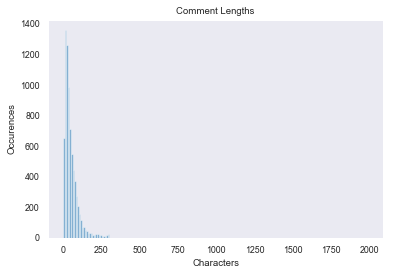

In [23]:
sns.set_style("darkgrid")
sns.set_context("paper")
df['character_count'] = df['body'].map(lambda x : len(x))
plt.hist(df['character_count'], bins=np.arange(1,2000,10), alpha=0.5, label="Character Lengths");
plt.title('Comment Lengths');
plt.xlabel('Characters');
plt.ylabel('Occurences');
plt.grid(False);

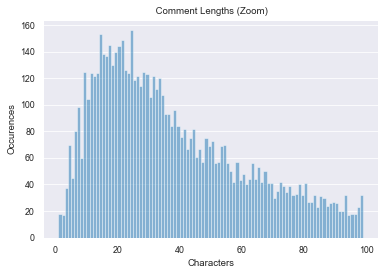

In [24]:
plt.hist(df['character_count'], bins=np.arange(1,100,1), alpha=0.5, label="Character Lengths");
plt.title(' Comment Lengths (Zoom)');
plt.xlabel('Characters');
plt.ylabel('Occurences');
ax = plt.gca()
ax.xaxis.grid(False) 

First, we can look at the time that a comment is posted and see how that relates to its popularity.

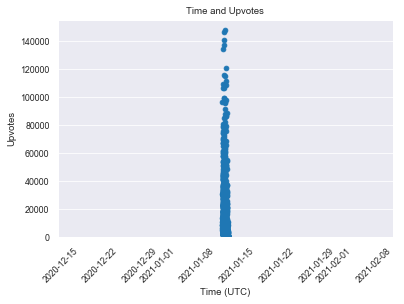

In [25]:
plt.scatter(df['created_utc'], df['ups']);
plt.title('Time and Upvotes');
plt.xlabel('Time (UTC)');
plt.xticks(rotation = 45)
plt.ylabel('Upvotes');
plt.ylim(ymin=-0.1);
ax = plt.gca();
ax.xaxis.grid(False)

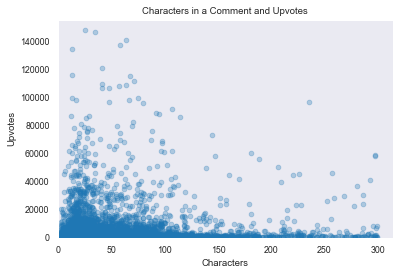

In [26]:

plt.scatter(df['character_count'], df['ups'], alpha=0.3);
plt.ylim(ymin=-0.1);
plt.xlim(xmin=-0.1);
plt.title('Characters in a Comment and Upvotes');
plt.xlabel('Characters');
plt.ylabel('Upvotes');
plt.grid(False)


### Dependent variable

In [28]:
df[df['score']!=df['ups']]

,body,created_utc,ups,downs,upvote_ratio,score,gilded,over_18,number_of_Comments,author,archived,edited,link_id,url,character_count


So , the dependent variable can be either be score or ups

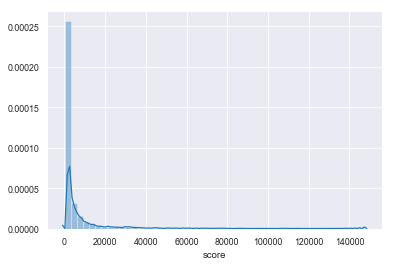

In [29]:
sns.distplot(df["score"])

### InDependent variable -Body

### Word Count

In [30]:
def word_count(text):
    wordList = re.sub("[^\w]", " ",  text).split()
    return len(wordList)

df['word_count'] = df['body'].map(lambda x : word_count(x))

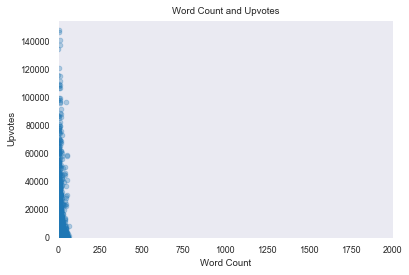

In [31]:
plt.scatter(df['word_count'], df['ups'], alpha=0.3);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Upvotes');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);
plt.grid(False)

#### Word Cloud of Comments

In [32]:
body_text = ' '.join(df['body'].str.lower())


In [33]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove("not")
stop_words.remove("no")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keerthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


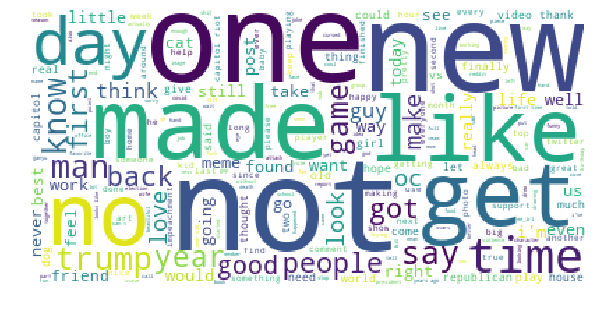

In [34]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=1000).generate(body_text)
rcParams['figure.figsize'] = 10, 10
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Cleaning the comments 


Here is the list of operation we are going to execute:

* We will keep stopwords: "No, Not" as it can be useful in sentiment analysis, in all cases TFIDF will detect them and we can keep them apart from our study.
* Remove numbers, symbols and punctuations (except for comma, which will be removed later)
* Replace URLs with URL token.

We change body into a string variable:

In [35]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove("not")
stop_words.remove("no")

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def spaceURLs(df, column):
    '''This method is used to enforce proper spacing
    Ex: In the data, you may have '[the image](https://image.xyz)';
    this method creates space between alt text ("the image") and the URL.'''
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\[|\]', ' ', regex=True)
    return data

def replaceURL(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\(http\S+', 'URL', regex=True)
    return data

def removeSymbols(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('/r/', '', regex=True)
    data.loc[:, column] = data[column].str.replace('[^\.\'A-Za-z0-9]+', ' ', regex=True)
    return data

def removeNumbers(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\S*\d\S*', '', regex=True)
    return data


In [36]:
# Remove stop words
stop_words = stopwords.words('english')
stop_words.extend(["ca","http"])
def no_stop_words(list_tokens):    
    tokens_no_stop_word = []
    for elt in list_tokens: 
        tokens_no_stop_word.append([tok for tok in elt if tok not in stop_words])
    return(tokens_no_stop_word)

In [37]:
data = spaceURLs(df, 'body')
data = replaceURL(data, 'body')
data = removeNumbers(data, 'body')
data = removeSymbols(data, 'body')


In [38]:
data.head().T

,0,1,2,3,4
body,I Can Feel The Rage,Zenith of the art form,Fox News McConnell believes Trump committed im...,'I'm not a magician' Lawyer for man pictured w...,A mother's reaction after seeing her son has p...
created_utc,2021-01-13 06:14:53,2021-01-13 05:54:34,2021-01-12 22:37:36,2021-01-12 15:21:59,2021-01-13 00:18:34
ups,21156,22020,30701,61881,108510
downs,0,0,0,0,0
upvote_ratio,0.94,0.98,0.77,0.91,0.84
score,21156,22020,30701,61881,108510
gilded,0,0,1,0,8
over_18,False,False,False,False,False
number_of_Comments,465,262,5185,4444,4154
author,Halzman,KevlarYarmulke,juicesalinas,ClaraWhoWastedAway,americanthaiguy


In [39]:
df = data.copy()

### Sentimental Analaysis -- Assigning Polarity to the BODY

In [40]:
def get_subjectivity(df):
    df['subjectivity'] = df['body'].str.count('I ')
    print(f"We found {sum(df.subjectivity)} I's in comments.")
    return(df)

In [41]:
df = get_subjectivity(df)

We found 1095 I's in comments.


In [42]:

def get_exclamation(df):
    df['exclamation'] = df['body'].str.count('!')
    print(f"We found {sum(df.exclamation)} exclamation marks in all comments.")
    return(df)

In [43]:
df = get_exclamation(df)

We found 0 exclamation marks in all comments.


In [44]:
# Create a function to get the subjectivity
def Subjectivity(text):
       return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def Polarity(text):
      return  TextBlob(text).sentiment.polarity

In [45]:
df['Subjectivity'] =data['body'].apply(Subjectivity)
df['Polarity'] =data['body'].apply(Polarity)

In [46]:
senti = SentimentIntensityAnalyzer()
for sentence in df['body']:
    ss = senti.polarity_scores(sentence)

In [47]:
pickle.dump(senti, open('senti.pkl','wb'))

In [48]:
#analyzer = SentimentIntensityAnalyzer()
df['rating'] = df['body'].apply(senti.polarity_scores)


In [49]:
df = pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)

In [50]:
df.head(1)

,body,created_utc,ups,downs,upvote_ratio,score,gilded,over_18,number_of_Comments,author,...,character_count,word_count,subjectivity,exclamation,Subjectivity,Polarity,neg,neu,pos,compound
0,I Can Feel The Rage,2021-01-13 06:14:53,21156,0,0.94,21156,0,False,465,Halzman,...,19,5,1,0,0.0,0.0,0.474,0.526,0.0,-0.5574


In [51]:
# data preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_preprocess(text):
    text = re.sub(r'[^\w\s]', '', text) 
    l_text = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    stem_words = [stemmer.stem(w) for w in l_text]
    lemma_words = [lemmatizer.lemmatize(w) for w in l_text]

    return " ".join(lemma_words)

df['body'] = df['body'].map(lambda com : text_preprocess(com))

In [52]:
df.head().T

,0,1,2,3,4
body,feel rage,zenith art form,fox news mcconnell belief trump committed impe...,im magician lawyer man pictured lectern capito...,mother reaction seeing son passed bar exam
created_utc,2021-01-13 06:14:53,2021-01-13 05:54:34,2021-01-12 22:37:36,2021-01-12 15:21:59,2021-01-13 00:18:34
ups,21156,22020,30701,61881,108510
downs,0,0,0,0,0
upvote_ratio,0.94,0.98,0.77,0.91,0.84
score,21156,22020,30701,61881,108510
gilded,0,0,1,0,8
over_18,False,False,False,False,False
number_of_Comments,465,262,5185,4444,4154
author,Halzman,KevlarYarmulke,juicesalinas,ClaraWhoWastedAway,americanthaiguy


In [53]:
df.reset_index(inplace=True, drop=True)

In [54]:
df.columns

Index(['body', 'created_utc', 'ups', 'downs', 'upvote_ratio', 'score',
       'gilded', 'over_18', 'number_of_Comments', 'author', 'archived',
       'edited', 'link_id', 'url', 'character_count', 'word_count',
       'subjectivity', 'exclamation', 'Subjectivity', 'Polarity', 'neg', 'neu',
       'pos', 'compound'],
      dtype='object')

to check by deleting : downs,upvote_ratio
deleted -Subjectivity

In [56]:
df.drop(['created_utc','ups','author','archived','edited','link_id','url','subjectivity','character_count','exclamation'], axis=1, inplace=True) 

In [57]:
df.columns

Index(['body', 'downs', 'upvote_ratio', 'score', 'gilded', 'over_18',
       'number_of_Comments', 'word_count', 'Subjectivity', 'Polarity', 'neg',
       'neu', 'pos', 'compound'],
      dtype='object')

### Spliting Data into Train and test

In [58]:
X= df.drop(['score'], axis=1)
y = df['score']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [60]:
X_train.columns

Index(['body', 'downs', 'upvote_ratio', 'gilded', 'over_18',
       'number_of_Comments', 'word_count', 'Subjectivity', 'Polarity', 'neg',
       'neu', 'pos', 'compound'],
      dtype='object')

In [61]:
X_train.head()

,body,downs,upvote_ratio,gilded,over_18,number_of_Comments,word_count,Subjectivity,Polarity,neg,neu,pos,compound
7409,chuck norris forced deny capitol riot lookalik...,0,0.98,0,False,59,16,0.200000,-0.300000,0.420,0.580,0.000,-0.8271
151,slpt quickly heat bath,0,0.97,0,False,46,6,0.500000,0.333333,0.000,1.000,0.000,0.0000
915,finale canada drag race ilona verley spirit me...,0,0.97,0,False,18,39,0.124167,0.040000,0.184,0.713,0.104,-0.5719
1305,chernobyl s finest,0,0.97,0,False,127,3,0.000000,0.000000,0.000,1.000,0.000,0.0000
4174,depression hotline,0,0.98,0,False,15,2,0.000000,0.000000,0.787,0.213,0.000,-0.5719


In [62]:
X_train.isna().sum()

body                  0
downs                 0
upvote_ratio          0
gilded                0
over_18               0
number_of_Comments    0
word_count            0
Subjectivity          0
Polarity              0
neg                   0
neu                   0
pos                   0
compound              0
dtype: int64

### One Hot Encoding for Categorical variables 

In [63]:
categories = ['over_18']
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[categories])
pickle.dump(ohe, open('one_hot.pkl','wb'))
col_names = [j for sub in ohe.categories_ for j in sub]

In [64]:
train_encoded = ohe.transform(X_train[categories])
test_encoded = ohe.transform(X_test[categories])

In [65]:
train_ohe = pd.DataFrame(train_encoded.todense(), columns=col_names)
test_ohe = pd.DataFrame(test_encoded.todense(), columns=col_names)

In [66]:
train_ohe.head()

,False,True
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [67]:
train_ohe.isna().sum()

False    0
True     0
dtype: int64

### Converting "body" to Vector

In [68]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['body'])

In [69]:
word_ind = tokenizer.word_index
word_token = {k:[word_ind[k]] for k in word_ind}
df_word_token = pd.DataFrame(word_token)
df_word_token.to_csv('word_token.csv', header=True, index=False)

**Global Vectors for Word Representation for "body"**

In [70]:
glove_txt = open('glove.6B.100d.txt', encoding="utf8")
embed_dict = dict()
for line in glove_txt:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embed_dict[word] = vector_dimensions
glove_txt.close()

embed_mat = zeros((len(word_ind) + 1, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embed_dict.get(word)
    if embedding_vector is not None:
        embed_mat[index] = embedding_vector


In [71]:
df_embed_mat = pd.DataFrame(data=embed_mat.astype(float))
df_embed_mat.to_csv('embed_mat.csv', sep=' ', header=True, float_format='%.2f', index=False)

**using glove vectors to assign vector value for body**

In [72]:
max_len = 300
## train data
train_body = pad_sequences(tokenizer.texts_to_sequences(X_train["body"]), padding='post', maxlen=max_len)
train = {}
df_train_body = []
for i, sentence in enumerate(train_body):
    vectors = []
    for n in sentence:
        vectors.append(embed_mat[n])
    train[i] = vectors
for key in train:
    arr = np.array(train[key])
    df_train_body.append(np.mean(arr, axis=0))
## test data
test_body = pad_sequences(tokenizer.texts_to_sequences(X_test["body"]), padding='post', maxlen=max_len)
test = {}
df_test_body = []
for i, sentence in enumerate(test_body):
    vectors = []
    for n in sentence:
        vectors.append(embed_mat[n])
    test[i] = vectors
for key in test:
    arr = np.array(test[key])
    df_test_body.append(np.mean(arr, axis=0))

In [73]:
df_train_body = pd.DataFrame(np.array(df_train_body))
df_test_body = pd.DataFrame(np.array(df_test_body))

In [74]:
df_train_body.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.003370,-0.003523,-0.004173,-0.008333,-0.001417,0.010825,-0.001509,-0.002788,0.004485,-0.004330,...,0.003086,-0.008875,-0.004849,0.002067,0.000093,-0.006675,-0.001978,0.004342,0.009140,-0.001862
1,-0.004137,0.001770,-0.000142,-0.002831,-0.001959,0.002628,0.003400,0.003076,-0.001158,0.000659,...,-0.001769,-0.001576,0.001008,0.002208,-0.005153,-0.001037,0.001913,-0.000641,0.003917,-0.000868
2,0.004423,0.003638,0.028336,-0.012880,0.005124,0.019215,-0.003288,0.009847,-0.015111,-0.003508,...,-0.002716,-0.019373,-0.003544,0.012289,-0.027892,0.007886,-0.027369,-0.007612,0.017931,-0.010146
3,0.004442,0.008293,0.007236,0.001464,-0.003962,-0.004358,0.001587,0.000333,-0.004214,0.004974,...,0.003109,0.004650,0.003430,0.001328,-0.004065,0.000588,-0.001841,-0.003130,0.000736,-0.000013
4,0.000181,-0.001349,-0.000275,0.002980,-0.003648,0.003434,0.001145,-0.001554,0.001598,-0.002799,...,0.002082,0.004388,-0.000709,0.000011,0.004133,0.002951,0.003939,-0.003132,0.000218,0.000245


In [75]:
X_train.columns

Index(['body', 'downs', 'upvote_ratio', 'gilded', 'over_18',
       'number_of_Comments', 'word_count', 'Subjectivity', 'Polarity', 'neg',
       'neu', 'pos', 'compound'],
      dtype='object')

In [76]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)


In [77]:
X_train = pd.concat([X_train, df_train_body, train_ohe], axis=1)
X_test =  pd.concat([X_test, df_test_body, test_ohe], axis=1)

In [78]:
X_train.drop(["body","over_18"], axis=1, inplace=True)
X_test.drop(["body","over_18"], axis=1, inplace=True)

In [79]:
np.where(np.isnan(X_train), ma.array(X_train, mask=np.isnan(X_train)).mean(axis=0), X_train)  
np.where(np.isnan(X_test), ma.array(X_test, mask=np.isnan(X_test)).mean(axis=0), X_test)  

array([[ 0.00000000e+00,  9.80000000e-01,  0.00000000e+00, ...,
         3.19130003e-03,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.80000000e-01,  0.00000000e+00, ...,
        -2.72476673e-03,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.80000000e-01,  0.00000000e+00, ...,
         3.52799992e-04,  1.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00, ...,
        -4.65000023e-04,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00, ...,
         5.41056663e-03,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.60000000e-01,  0.00000000e+00, ...,
        -1.52243331e-03,  1.00000000e+00,  0.00000000e+00]])

In [80]:
X_train.shape , X_test.shape

((5301, 113), (2273, 113))

In [81]:
def model_diagnostics(model):
    train_pred = model.predict(X_train)
    r2 = r2_score(y_train, train_pred)
    mse = mean_squared_error(y_train, train_pred)
    mae = mean_absolute_error(y_train, train_pred)
    print(f"R-Sq of train data: {r2:.4}")
    print(f"RMSE of train data: {np.sqrt(mse)}")
    print(f"MAE  of train data: {mae}")
    print("*"*60)
    
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    print(f"R-Sq of test data: {r2:.4}")
    print(f"RMSE of test data: {np.sqrt(mse)}")
    print(f"MAE of test data: {mae}")
    
    return [r2,np.sqrt(mse),mae]  


model_metrics = dict()

# Modelling 

### Linear Regression

In [83]:
linear = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
linear.fit(X_train,y_train)
model_metrics["Linear Regression"] = model_diagnostics(linear)

R-Sq of train data: 0.3823
RMSE of train data: 8893.69966350672
MAE  of train data: 4142.344542155961
************************************************************
R-Sq of test data: 0.3064
RMSE of test data: 8010.104279421352
MAE of test data: 3995.3615850472943


### Regularisation of Linear Regression

In [84]:
elastic_net = ElasticNetCV(cv = 30).fit(X_train, y_train)
model_metrics["Elastic Net Regression"] = model_diagnostics(elastic_net)

R-Sq of train data: 0.2818
RMSE of train data: 9590.289201600848
MAE  of train data: 4459.892866349639
************************************************************
R-Sq of test data: 0.2373
RMSE of test data: 8399.27730773281
MAE of test data: 4200.314261345736


In [85]:
elastic_net.alpha_


161013.75736098745

### Decision Tree Regression

In [86]:
dt_cv=model_selection.GridSearchCV(DecisionTreeRegressor(),param_grid=[{'max_depth':[2,3,4,5,6,7,None],
                                                                        "max_features":[1,2,3,4],
                                                                        "min_samples_split": np.arange(35,55,5),
                                                                        "min_samples_leaf": np.arange(35,55,5)}],cv=10)
dt_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, None],
                          'max_features': [1, 2, 3, 4],
                          'min_samples_leaf': array([35, 40, 45, 50]),
                          'min_samples_split': array([35, 40, 45, 50])}])

In [87]:
dt_cv.best_estimator_

DecisionTreeRegressor(max_depth=4, max_features=4, min_samples_leaf=40,
                      min_samples_split=45)

In [88]:
dt = DecisionTreeRegressor(max_depth=6, max_features=4,min_samples_split=50, min_samples_leaf=40, random_state = 10)
dt.fit(X_train, y_train)
model_metrics["Decision Tree"] = model_diagnostics(dt)


R-Sq of train data: 0.02907
RMSE of train data: 11150.666738522103
MAE  of train data: 5295.861536162979
************************************************************
R-Sq of test data: -0.03086
RMSE of test data: 9765.086588040833
MAE of test data: 5080.004750138055


### Random Forest Regression

In [89]:
rf_cv=model_selection.GridSearchCV(RandomForestRegressor(),param_grid=[{'min_samples_leaf': [1, 5,10],
                                                                         'min_samples_split': [ 5, 10],
                                                                         'n_estimators': [10,50,70]}])

rf_cv.fit(X_train,y_train)

In [90]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train) 
model_metrics["Random Forest"] = model_diagnostics(rf)

R-Sq of train data: 0.7789
RMSE of train data: 5321.282422360817
MAE  of train data: 2055.8962436148945
************************************************************
R-Sq of test data: 0.4772
RMSE of test data: 6953.883521261184
MAE of test data: 2863.126472728838


### Gradient Boosting Regressor

In [91]:
gbr_cv= model_selection.GridSearchCV(GradientBoostingRegressor(),param_grid=[{'n_estimators':[500,1000,2000],
                                                                              'learning_rate':[.001,0.01,.1],
                                                                              'max_depth':[1,2,4],
                                                                              'subsample':[.5,.75,1],
                                                                              'random_state':[10]}])

gbr_cv.fit(X_train,y_train)

In [92]:
gbr = GradientBoostingRegressor(n_estimators=70, max_depth=5,learning_rate=0.01, random_state = 10)
gbr.fit(X_train, y_train)
model_metrics["Gradient Boosting Regression"] = model_diagnostics(gbr)

R-Sq of train data: 0.5878
RMSE of train data: 7265.366395524566
MAE  of train data: 3565.9334086102394
************************************************************
R-Sq of test data: 0.4239
RMSE of test data: 7300.316234911899
MAE of test data: 3572.2645627726033


### XG Boost Regressor

In [93]:
xgbr_cv= model_selection.GridSearchCV(xgb.XGBRegressor(),param_grid=[{'nthread':[4],
                                                                  'learning_rate': [.03, 0.05, .07], 
                                                                  'max_depth': [5, 6, 7],
                                                                  'subsample': [0.7],
                                                                  'colsample_bytree': [0.7],
                                                                  'n_estimators': [500]}],cv = 2,n_jobs = 5,verbose=True)

In [94]:
xgbr_cv.fit(X_train,y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  1.9min finished


[23:12:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid=[{'colsample_bytree': [0.7],
                          'learning_rate': [0.03, 0.05, 0.07],
                          'max_depth': [5, 6, 7], 'n_estimators': [500],
                          'nthread': [4], 'subsample': [0.7]}],
             verbose=True)

In [95]:
print('Best parameters found by grid search are:',xgbr_cv.best_params_)

Best parameters found by grid search are: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'nthread': 4, 'subsample': 0.7}


In [96]:
xgbr = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 5, n_estimators= 500,
                        nthread= 4, subsample= 0.7)
xgbr.fit(X_train, y_train)
model_metrics["XG Boost Regression"] = model_diagnostics(xgbr)

[23:12:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R-Sq of train data: 0.9628
RMSE of train data: 2181.899062399816
MAE  of train data: 1230.228932681162
************************************************************
R-Sq of test data: 0.5409
RMSE of test data: 6516.622139415082
MAE of test data: 2819.544865599457


### LG Boost Regressor

In [98]:
lgbr_cv=model_selection.GridSearchCV(lgbm.LGBMRegressor(),param_grid=[{'learning_rate': [0.01, 0.1, 1],
                                                                  'n_estimators': [20, 40]}], cv=3)

In [99]:
lgbr_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.01, 0.1, 1],
                          'n_estimators': [20, 40]}])

In [100]:
print('Best parameters found by grid search are:', lgbr_cv.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 20}


In [101]:
lgbr=lgbm.LGBMRegressor(learning_rate= 0.1, n_estimators= 20)
lgbr.fit(X_train, y_train)
model_metrics["LG Boost Regression"] = model_diagnostics(lgbr)

R-Sq of train data: 0.8056
RMSE of train data: 4990.028669016591
MAE  of train data: 2297.225312052588
************************************************************
R-Sq of test data: 0.5313
RMSE of test data: 6584.414086308942
MAE of test data: 2915.157861025196


### Model comparison

We compare the models based on three metrics: RMSE, MAE, and R2. To do so, we define the function below.

In [102]:
def model_comparison(model_metrics, sort_by = 'RMSE', metric = 'RMSE'):

    Rsq_list = []
    RMSE_list = []
    MAE_list = []
    for key in model_metrics.keys():
        Rsq_list.append(round(model_metrics[key][0],2))
        RMSE_list.append(round(model_metrics[key][1],0))
        MAE_list.append(round(model_metrics[key][2],0))

    props = pd.DataFrame([])

    props["R-squared"] = Rsq_list
    props["RMSE"] = RMSE_list
    props["MAE"] = MAE_list
    props.index = model_metrics.keys()
    props = props.sort_values(by = sort_by, ascending=False)

    fig, ax = plt.subplots(figsize = (12,6))

    ax.bar(props.index.sort_values(), props[metric], color="blue")
    xt = props.index
    ax.set_xticklabels(xt)
    plt.title(metric)
    plt.xlabel('Model') 
    plt.xticks(rotation = 45)
    plt.ylabel(metric)
    
   
    for i, v in enumerate(props[metric]):
        ax.text(i-.25, 
              v/props[metric][i]-.8, 
              props[metric][i], 
              fontsize=9, 
              color='WHITE')

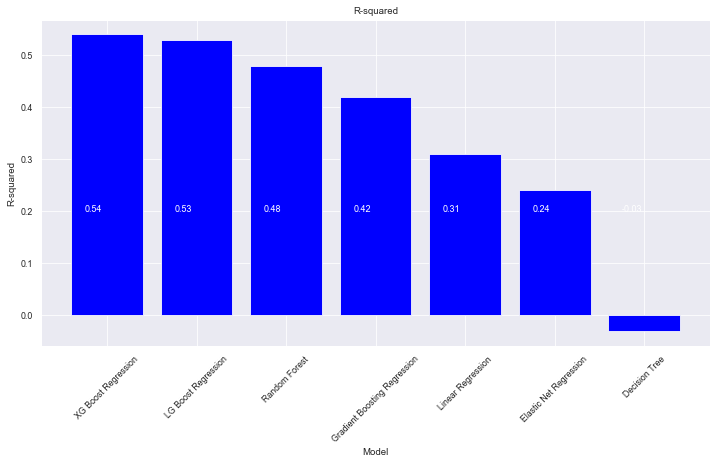

In [103]:
model_comparison(model_metrics, sort_by = 'R-squared', metric = 'R-squared')

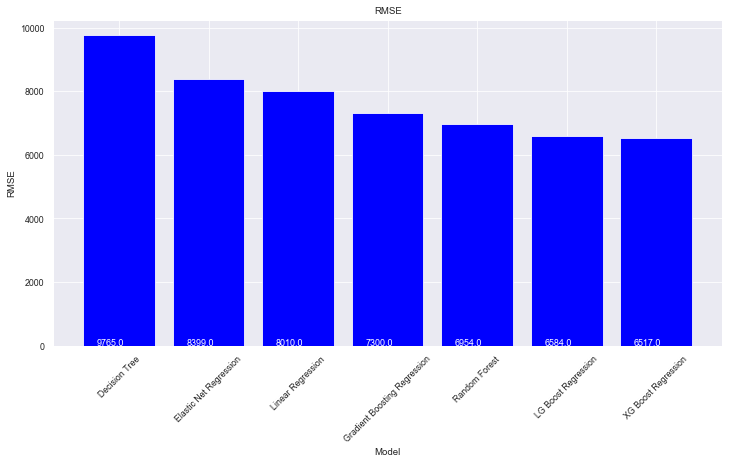

In [104]:
model_comparison(model_metrics, sort_by = 'RMSE', metric = 'RMSE')


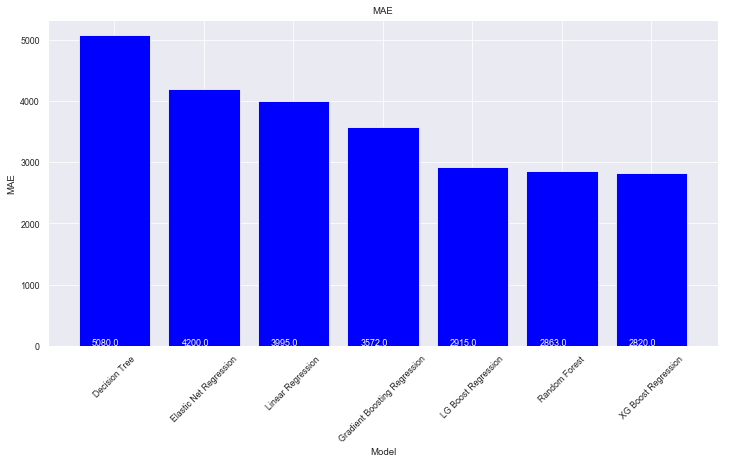

In [105]:
model_comparison(model_metrics, sort_by = 'MAE', metric = 'MAE')

#### Based on R-square, RMSE and MAE , XG Boost Regressor is performing at par compared to other models. 

**Creating Booster file to load XGBoost Regressor**

In [97]:
from xgboost import Booster
xgbr.save_model('xgbr.booster')

